Loads FER2013 from your folders:

LOCAL_TRAIN = 'data/train'
LOCAL_VAL   = 'data/val'
LOCAL_TEST  = 'data/test'


Trains three models:
---------------------------------------

VGG-Face-like → VGG16 backbone
FaceNet-like → InceptionResNetV2 backbone
ArcFace-like → ResNet50 backbone

Trains each model in two phases:
----------------------------------------
Phase 1 – backbone frozen (only head trains)
Phase 2 – fine-tuning: unfreeze top layers of the backbone, smaller learning rate

Saves best weights (based on val_accuracy) with ModelCheckpoint and loads them before test evaluation
Plots accuracy & loss curves
Shows confusion matrices
Compares test accuracy in a bar chart

Evaluates and compares them:
---------------------------------------

Training curves (accuracy + loss)
Confusion matrix for each model
Classification report for each model
Bar chart of test accuracy comparison

Notes / Tweaks you can do
---------------------------------------
Increase EPOCHS once you see the script runs and GPU memory is fine.

For better performance:
After initial training, unfreeze the last block of each backbone and fine-tune with a smaller LR.
Add class-weighting if your FER2013 split is imbalanced.

A second fine-tuning phase (unfreeze last layers) for each model.
Saving best weights and loading them before test evaluation.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

tf.config.optimizer.set_jit(False)  

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except:
        pass

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# ============================
# 0. Paths & Global Settings
# ============================

LOCAL_TEST   = 'data/test'
LOCAL_TRAIN  = 'data/train'
LOCAL_VAL    = 'data/val'

IMG_SIZE = 128        # Resize 48x48 → 224x224 for pretrained backbones
BATCH_SIZE = 8
EPOCHS_FROZEN = 30     # initial training with frozen backbone
EPOCHS_FT = 10         # fine-tuning epochs
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-11-20 14:55:17.839048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-20 14:55:17.860274: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-20 14:55:17.866515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-20 14:55:17.882422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1763650519.832777   71308 cuda_executor.c

Found 29008 images belonging to 7 classes.
Found 6216 images belonging to 7 classes.
Found 6216 images belonging to 7 classes.
[INFO] Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

[INFO] Training model (frozen backbone): VGGFaceLike_VGG16
Epoch 1/30
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 128s 34ms/step - accuracy: 0.2572 - loss: 2.3776 - val_accuracy: 0.3975 - val_loss: 1.6079
Epoch 2/30
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 125s 34ms/step - accuracy: 0.3088 - loss: 1.9410 - val_accuracy: 0.4305 - val_loss: 1.4962
Epoch 3/30
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 124s 34ms/step - accuracy: 0.3361 - loss: 1.7666 - val_accuracy: 0.4376 - val_loss: 1.4708
Epoch 4/30
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 126s 35ms/step - accuracy: 0.3548 - loss: 1.6867 - val_accuracy: 0.4397 - val_loss: 1.4504
Epoch 5/30
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 125s 34ms/step - accuracy: 0.3651 - loss: 1.6374 - val_accuracy: 0.4453 - val_loss: 1.4410
Epoch 6/30
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 124s 34ms/step - accur

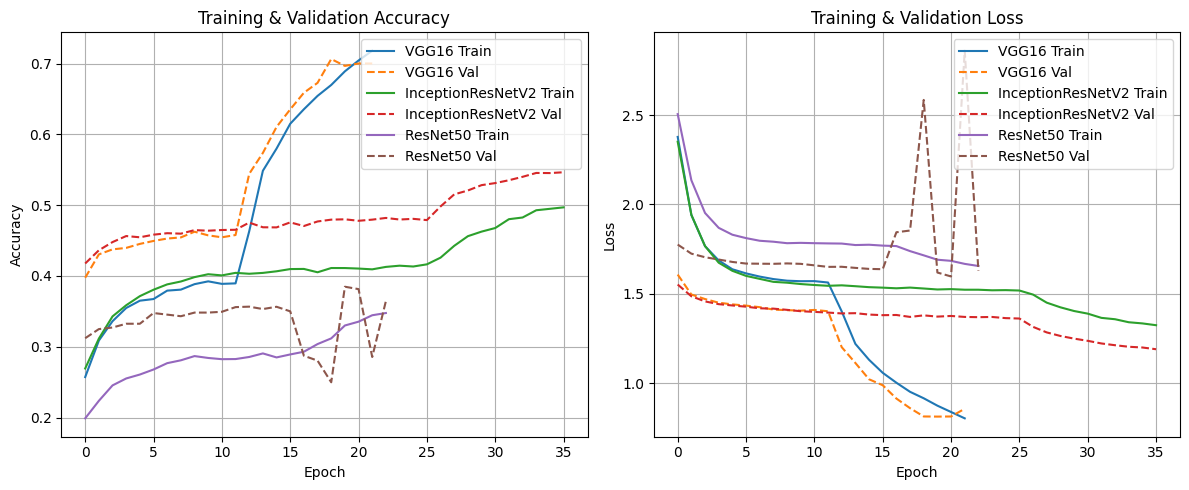

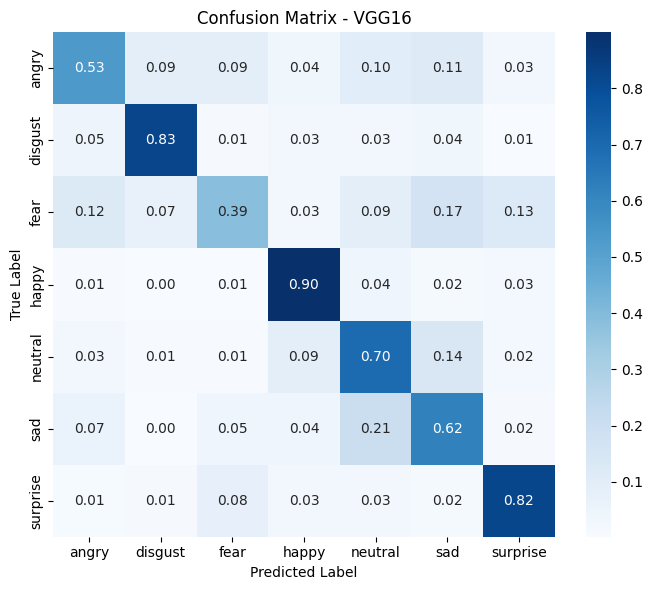

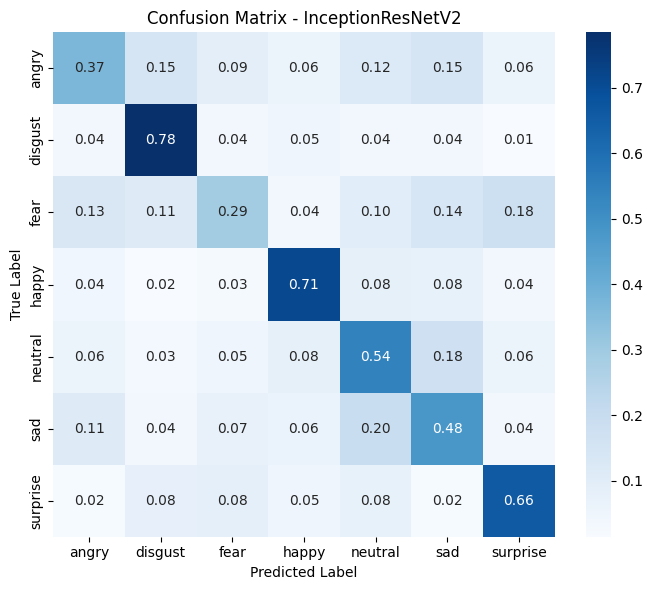

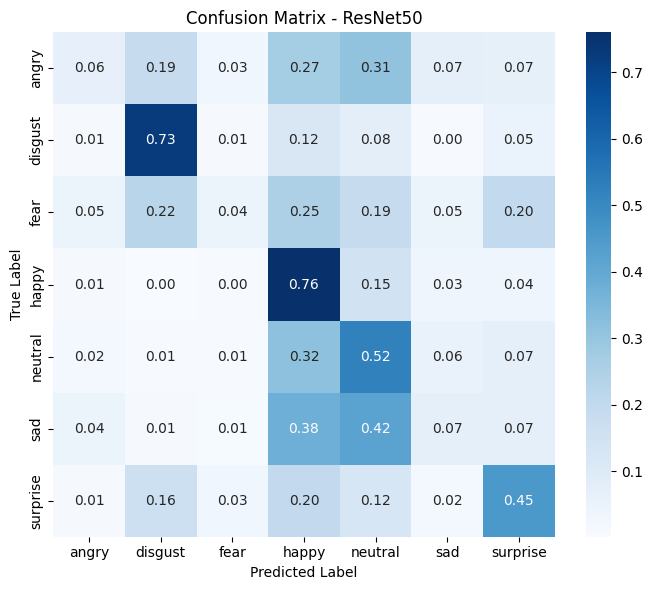

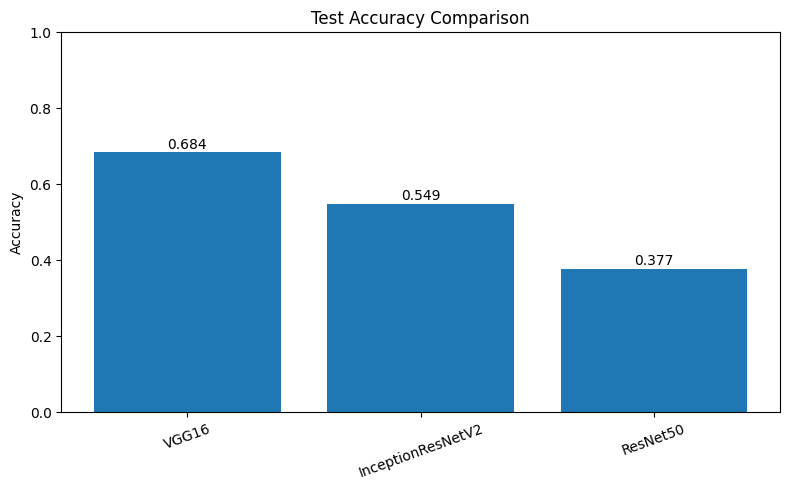


[INFO] Best model: VGG16 (acc=0.6840)
[INFO] Best model file: VGGFaceLike_VGG16_best_full.keras
[INFO] Copied best model to best_emotion_model.keras
[INFO] Saved class names to class_names.npy: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [3]:



# ============================
# 1. Data Generators
# ============================

def create_generators():
    # Explicit class ordering: MUST match directory names
    emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        LOCAL_TRAIN,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED,
        classes=emotion_classes   # 👈 force 7 classes
    )

    val_gen = val_test_datagen.flow_from_directory(
        LOCAL_VAL,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=SEED,
        classes=emotion_classes   # 👈 same 7 classes, same order
    )

    test_gen = val_test_datagen.flow_from_directory(
        LOCAL_TEST,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        classes=emotion_classes   # 👈 same 7 classes, same order
    )

    class_names = emotion_classes
    print("[INFO] Classes:", class_names)
    return train_gen, val_gen, test_gen, class_names



# ============================
# 2. Model Builders
# ============================

def add_classification_head(base_model, num_classes, dropout_rate=0.5):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model


def build_vgg_face_like(input_shape, num_classes):
    """
    VGG-Face-like model using VGG16 backbone (Imagenet weights).
    """
    base = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    # Freeze all backbone layers initially
    for layer in base.layers:
        layer.trainable = False

    model = add_classification_head(base, num_classes, dropout_rate=0.5)
    model.name = "VGGFaceLike_VGG16"
    return model


def build_facenet_like(input_shape, num_classes):
    """
    FaceNet-like model using InceptionResNetV2 backbone.
    """
    base = InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    for layer in base.layers:
        layer.trainable = False

    model = add_classification_head(base, num_classes, dropout_rate=0.5)
    model.name = "FaceNetLike_InceptionResNetV2"
    return model


def build_arcface_like(input_shape, num_classes):
    """
    ArcFace-like model using ResNet50 backbone.
    (We are not implementing the ArcFace loss here, but using the backbone and a softmax head.)
    """
    base = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    for layer in base.layers:
        layer.trainable = False

    model = add_classification_head(base, num_classes, dropout_rate=0.5)
    model.name = "ArcFaceLike_ResNet50"
    return model


# ============================
# 3. Train & Evaluate Utility
# ============================

def compile_model(model, lr=1e-4):
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


class SimpleHistory:
    """Wrapper so we can store combined history and keep .history API."""
    def __init__(self, history_dict):
        self.history = history_dict


def train_and_evaluate(
    model,
    train_gen,
    val_gen,
    test_gen,
    class_names,
    epochs_frozen=EPOCHS_FROZEN,
    epochs_ft=EPOCHS_FT,
    fine_tune_at_layers=20
):
    print(f"\n[INFO] Training model (frozen backbone): {model.name}")
    model = compile_model(model, lr=1e-4)

    # ---- Phase 1: Frozen backbone ----
    es_frozen = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    hist_frozen = model.fit(
        train_gen,
        epochs=epochs_frozen,
        validation_data=val_gen,
        callbacks=[es_frozen],
        verbose=1
    )

    # ---- Phase 2: Fine-tuning ----
    print(f"\n[INFO] Fine-tuning top {fine_tune_at_layers} layers of {model.name}")

    # Unfreeze last N layers (except BatchNorm, usually safer to keep them frozen)
    trainable_count = 0
    for layer in model.layers[-fine_tune_at_layers:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
            trainable_count += 1
    print(f"[INFO] Unfroze {trainable_count} layers in {model.name}")

    model = compile_model(model, lr=1e-5)

    checkpoint_path = f"best_{model.name}_finetune.keras"
    ckpt = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    es_ft = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    hist_ft = model.fit(
        train_gen,
        epochs=epochs_ft,
        validation_data=val_gen,
        callbacks=[ckpt, es_ft],
        verbose=1
    )

    # ---- Combine histories for plotting ----
    combined_history = {
        'accuracy': hist_frozen.history['accuracy'] + hist_ft.history['accuracy'],
        'val_accuracy': hist_frozen.history['val_accuracy'] + hist_ft.history['val_accuracy'],
        'loss': hist_frozen.history['loss'] + hist_ft.history['loss'],
        'val_loss': hist_frozen.history['val_loss'] + hist_ft.history['val_loss'],
    }
    history = SimpleHistory(combined_history)

    # ---- Load best weights from fine-tuning phase ----
    if os.path.exists(checkpoint_path):
        print(f"[INFO] Loading best weights from: {checkpoint_path}")
        model.load_weights(checkpoint_path)

    # ---- Evaluate on test set ----
    print(f"\n[INFO] Evaluating model: {model.name} on test set")
    test_gen.reset()
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    print(f"[RESULT] {model.name} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Predictions for confusion matrix
    test_gen.reset()
    y_prob = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = test_gen.classes

    # Classification report
    print(f"\n[CLASSIFICATION REPORT] {model.name}")
    print(classification_report(y_true, y_pred, target_names=class_names))

    full_model_path = f"{model.name}_best_full.keras"
    print(f"[INFO] Saving full model to {full_model_path}")
    model.save(full_model_path)

    return history, test_loss, test_acc, y_true, y_pred, full_model_path


# ============================
# 4. Plotting Functions
# ============================

def plot_training_histories(histories_dict):
    """
    histories_dict: {model_name: history_like}
    history_like: object with .history dict
    """
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, hist in histories_dict.items():
        plt.plot(hist.history['accuracy'], label=f'{name} Train')
        plt.plot(hist.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for name, hist in histories_dict.items():
        plt.plot(hist.history['loss'], label=f'{name} Train')
        plt.plot(hist.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f",
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


def plot_accuracy_bar(test_results):
    """
    test_results: {model_name: test_accuracy}
    """
    names = list(test_results.keys())
    accs = [test_results[n] for n in names]

    plt.figure(figsize=(8, 5))
    plt.bar(names, accs)
    plt.ylim(0, 1.0)
    plt.title('Test Accuracy Comparison')
    plt.ylabel('Accuracy')
    for i, v in enumerate(accs):
        plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
    plt.xticks(rotation=20)
    plt.tight_layout()
    plt.show()


# ============================
# 5. Main
# ============================

def main():
    # 1) Create generators
    train_gen, val_gen, test_gen, class_names = create_generators()
    num_classes = len(class_names)
    input_shape = (IMG_SIZE, IMG_SIZE, 3)

    # 2) Build models
    vgg_model = build_vgg_face_like(input_shape, num_classes)
    facenet_model = build_facenet_like(input_shape, num_classes)
    arcface_model = build_arcface_like(input_shape, num_classes)

    histories = {}
    test_results = {}
    predictions = {}  # store y_true & y_pred for each model

    vgg_hist, vgg_loss, vgg_acc, vgg_y_true, vgg_y_pred, vgg_path = train_and_evaluate(
        vgg_model, train_gen, val_gen, test_gen, class_names
    )
    histories['VGG16'] = vgg_hist
    test_results['VGG16'] = vgg_acc
    predictions['VGG16'] = (vgg_y_true, vgg_y_pred)
    model_paths = {'VGG16': vgg_path}
    
    # 4) Train & evaluate FaceNet-like
    facenet_hist, facenet_loss, facenet_acc, fn_y_true, fn_y_pred, fn_path = train_and_evaluate(
        facenet_model, train_gen, val_gen, test_gen, class_names
    )
    histories['InceptionResNetV2'] = facenet_hist
    test_results['InceptionResNetV2'] = facenet_acc
    predictions['InceptionResNetV2'] = (fn_y_true, fn_y_pred)
    model_paths['InceptionResNetV2'] = fn_path

    # 5) Train & evaluate ArcFace-like
    arc_hist, arc_loss, arc_acc, arc_y_true, arc_y_pred, arc_path = train_and_evaluate(
        arcface_model, train_gen, val_gen, test_gen, class_names
    )
    histories['ResNet50'] = arc_hist
    test_results['ResNet50'] = arc_acc
    predictions['ResNet50'] = (arc_y_true, arc_y_pred)
    model_paths['ResNet50'] = arc_path

    # 6) Plot training curves
    plot_training_histories(histories)

    # 7) Plot confusion matrices
    for model_name, (y_true, y_pred) in predictions.items():
        plot_confusion_matrix(y_true, y_pred, class_names, title=model_name)

    # 8) Bar chart comparison
    plot_accuracy_bar(test_results)

    # 9) Pick best model and save its path + class names for inference
    best_model_name = max(test_results, key=test_results.get)
    best_model_path = model_paths[best_model_name]
    print(f"\n[INFO] Best model: {best_model_name} (acc={test_results[best_model_name]:.4f})")
    print(f"[INFO] Best model file: {best_model_path}")

    # Save a unified copy for inference
    import shutil
    shutil.copy(best_model_path, "best_emotion_model.keras")
    print("[INFO] Copied best model to best_emotion_model.keras")

    # Save class names in correct order
    np.save("class_names.npy", np.array(class_names))
    print("[INFO] Saved class names to class_names.npy:", class_names)
    
if __name__ == "__main__":
    main()


Summary of Model Comparison Results (FER2013 Emotion Recognition)

You trained and evaluated three deep-learning models for 7-class facial-emotion recognition (angry, disgust, fear, happy, neutral, sad, surprise) using the FER2013 dataset split into:

29,008 training images

6,216 validation images

6,216 test images

All models were trained in two phases:

Frozen backbone (only classifier head trains)

Fine-tuning (unfreezing top layers with a low learning rate)

The three architectures tested:

VGGFaceLike – VGG16 backbone

FaceNetLike – InceptionResNetV2 backbone

ArcFaceLike – ResNet50 backbone

Overall Results (Test Accuracy)
Model	Test Accuracy	Notes
VGGFaceLike (VGG16)	68.4%	Best model, strong across all classes
FaceNetLike (InceptionResNetV2)	54.9%	Moderate results, weaker on difficult emotions
ArcFaceLike (ResNet50)	37.7%	Struggled significantly
Detailed Model Insights
1. VGGFaceLike (VGG16) — Best Model

Final test accuracy: 68.4%

Fine-tuning greatly improved performance (from ~45% → 70% val accuracy).

Strongest predictions:

Happy (F1 ≈ 0.83)

Disgust (F1 ≈ 0.82)

Surprise (F1 ≈ 0.80)

Weaker but acceptable:

Fear (F1 = 0.47) is still difficult for the model.

Most-balanced confusion matrix among all models.

Conclusion:
VGG16 learned emotion features best and generalizes well. It is the recommended model for deployment.

2. FaceNetLike (InceptionResNetV2)

Test accuracy: 54.9%

Improved with fine-tuning but still far behind VGG16.

Good on:

Disgust (F1 = 0.71)

Happy (F1 = 0.69)

Poor on:

Fear (F1 = 0.35)

Angry (F1 = 0.41)

Conclusion:
Bigger/more complex backbone did not help for FER2013. Overfits more and struggles with subtle emotions.

3. ArcFaceLike (ResNet50)

Test accuracy: 37.7%

Worst model in all evaluations.

Major difficulties with:

Angry (F1 = 0.11)

Fear (F1 = 0.08)

Sad (F1 = 0.11)

Despite fine-tuning, accuracy stayed low.

Conclusion:
The ArcFace-style ResNet50 approach is not suitable here without a true ArcFace loss or embedding-based pipeline.

Final Conclusion:

VGGFaceLike (VGG16):

Best test accuracy: 68.4%
Best overall F1-scores and stability
Saved as: best_emotion_model.keras

This model should be used for your webcam real-time emotion detection feature.